<a href="https://colab.research.google.com/github/rbarman/lfa/blob/master/lesson2/Office_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classify different characters of the office

In [0]:
!git clone https://github.com/rbarman/colabutils
!pip install -r colabutils/requirements.txt

Cloning into 'colabutils'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 71 (delta 28), reused 48 (delta 13), pack-reused 0
Unpacking objects: 100% (71/71), done.
    100% |████████████████████████████████| 911kB 19.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/23/84/3cec6d566b88bef64ad727a7e805f6544b8af4a8f121f9691c
Successfully built google-images-download


In [0]:
from colabutils import google as g
from fastai.vision import *
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Utility to clean up images**

Google colab does not allow external widgets so I can not use the fast ai image cleaner widget


*   https://forums.fast.ai/t/imagecleaner/37867/4
*   https://github.com/googlecolab/colabtools/issues/60

For now just manually see images at random and delete bad images on disk

In [0]:
fig, axarr = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
[ax.set_axis_off() for ax in axarr.ravel()]

for i,folder in enumerate(glob.glob(f'./downloads/*')):
  print('folder')
  img_paths = glob.glob(f'{folder}/*.png')
  for j,rand_path in enumerate(random.sample(img_paths,5)):
    img = mpimg.imread(rand_path,0)
    axarr[j,i].imshow(img)
    axarr[j,i].set_title(rand_path)
    print(f'\t{rand_path}')

In [0]:
!rm 		./downloads/'jim halpert'/'35. rare-photo-of-jim-halpert-35768048.png'

However this manual process takes a while as I had 100 images per class. I decided to download fewer number of images from each class to speed things up with the assumption that the top images will less likely be noisy

**Get Data**

In [0]:
g.download_imgs_from_google('michael scott',20)
g.download_imgs_from_google('dwight schrute',20)
g.download_imgs_from_google('jim halpert',20)


Item no.: 1 --> Item name = michael scott
Evaluating...
Starting Download...
Completed Image ====> 1. michaelscott.png
Completed Image ====> 2. 0e1587de-fd74-4e77-9264-62a0bf5e894a-nup_130296_0067.jpeg
Completed Image ====> 3. 170px-steve_carell_2010.jpg
Completed Image ====> 4. michael-scott-misquotations-office-video.jpg
Completed Image ====> 5. 350?cb=20170701090332.jpg
Completed Image ====> 6. c5576501-1a7a-43b8-b5e4-9f0aed1083e0.jpg
Completed Image ====> 7. e46c3d8de0c01966-600x338.jpg
Completed Image ====> 8. f-ih3bmt_400x400.png
Completed Image ====> 9. prisonmike.jpeg
Completed Image ====> 10. does-the-office-hold-up-gq.jpg
Completed Image ====> 11. nup_136341_0184-b75de06bfca6dac5f8f751bf1284dfdc71739af8-s800-c85.jpg
Completed Image ====> 12. michael-scott-the-office-halloween.jpg
Completed Image ====> 13. 1*njwxqsshwvk81anqcmbevw.jpeg
Completed Image ====> 14. michaelscott.jpg
Completed Image ====> 15. m5yuh6me81bz.png
Completed Image ====> 16. michael-scott-kanye-west.jpg
C

{'img_count': 20,
 'img_dir': 'downloads/jim halpert/',
 'keyword': 'jim halpert'}

In [0]:
!ls downloads/

'dwight schrute'  'jim halpert'  'michael scott'


In [0]:
np.random.seed(9000)
data = ImageDataBunch.from_folder('.', train="downloads", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs=3).normalize(imagenet_stats)

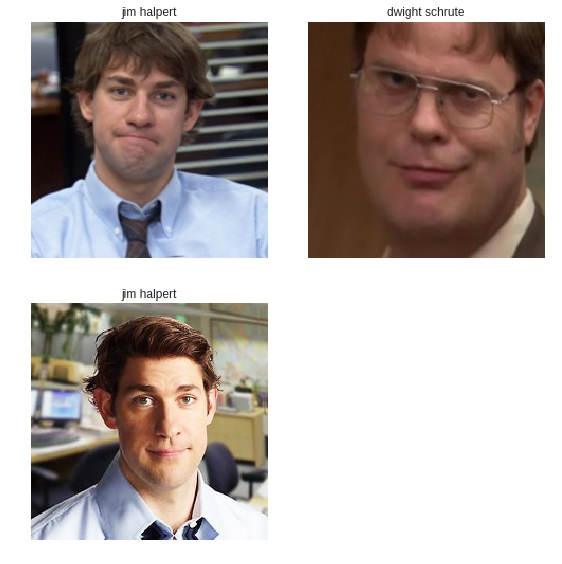

In [0]:
data.show_batch()

This random batch of data seems okay

**Train resnet50**

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.380506,0.315638,0.083333
2,0.955028,0.308007,0.083333
3,1.002446,0.265937,0.083333
4,0.794059,0.190974,0.083333


In [0]:
learn.save('stage-1')

Default resnet50 has ok performance. Let's try training all layers

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,0.561876,0.709133,0.250000
2,0.858818,0.749857,0.333333


In [0]:
learn.save('stage-2')

Performance is worse when training all layers at the default learning rate. Let's try finetuning by selecting better learning rates

In [0]:
learn.load('stage-1')
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06


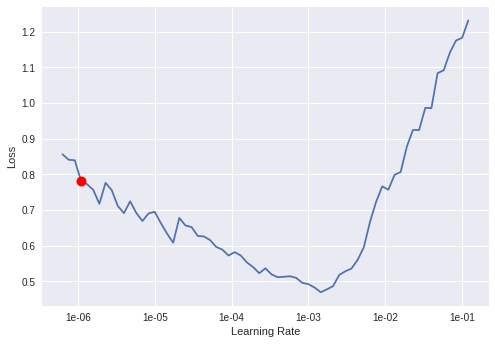

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(5e-5,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.688607,0.283894,0.083333
2,0.621247,0.290662,0.083333
3,0.784735,0.255026,0.083333
4,0.653759,0.210565,0.083333


In [0]:
learn.save('stage-3')

Finetuning results in the same error rate

In [0]:
!zip -r models.zip ./models/

  adding: models/ (stored 0%)
  adding: models/stage-3.pth (deflated 8%)
  adding: models/stage-2.pth (deflated 8%)
  adding: models/stage-1.pth (deflated 7%)
  adding: models/tmp.pth (deflated 8%)


In [0]:
from google.colab import files
files.download("./models.zip")

Next Steps:


*   Try adding more images to train on?
*   Adjust some default settings when creating the ImageDataBunch?
*   Or if 8.3% is okay for now, create a starlette app

